# C8. TP : Auto-Encodeur (en Keras, avec CNN)

# Partie 1 : AE-CNN sur données propres

## 1.1 Importation des modules

In [1]:
# On importe les librairies nécessaires

# Le dataset MNIST
from tensorflow.keras.datasets import mnist

# Les librairies TF pour le DL
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, UpSampling2D, Reshape
from tensorflow.keras.models import Model,Sequential

# Les librairies habituelles
import numpy as np
import matplotlib.pyplot as plt

# On configure la session pour l'utilisation de GPU
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)

# On désactive les warnings
import warnings
warnings.filterwarnings('ignore')

## 1.2 Définition de fonctions nécessaires

In [2]:
def MNIST_AE_disp(img_in, img_out, img_idx):

    num_img = len(img_idx)
    plt.figure(figsize=(18, 4))

    for i, image_idx in enumerate(img_idx):
        # on trace l'image originale
        ax = plt.subplot(2, num_img, i + 1)
        plt.imshow(img_in[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # on trace l'image bruitée
        ax = plt.subplot(2, num_img, num_img + i + 1)
        plt.imshow(img_out[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


## 1.3 Chargement et formatage des données (propres)

In [3]:
# On charge les données de MNIST (incluses dans Keras)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# On normalise les valeurs des pixels de [0, 255] à [0, 1]
x_train=x_train.astype('float32')/float(x_train.max())
x_test=x_test.astype('float32')/float(x_test.max())

# POUR LES CNN : On rajoute une dimension pour spécifier qu'il s'agit d'imgages en NdG
x_train=x_train.reshape(len(x_train),x_train.shape[1], x_train.shape[2], 1)
x_test=x_test.reshape(len(x_test),x_test.shape[1], x_test.shape[2], 1)

# On inspecte les dimensions de nos données
# Base d'entrainement : 60,000 images de dimension (28,28)
# Base de test : 10,000 images de dimension (28,28)
print("Training set : ",x_train.shape)
print("Testing set : ",x_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
Training set :  (60000, 28, 28, 1)
Testing set :  (10000, 28, 28, 1)


## 1.4 Création du réseau CNN

In [4]:
model = Sequential()

# Encoder ?
model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(8, (3,3), activation='relu', padding='same'))

# Decoder ?
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 2,633
Trainable params: 2,633
Non-trainable params: 0
______________________________________________________

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

## 1.5 Apprentissage du réseau

In [6]:
# On entraine le réseau
batch_size = 256                                                             # tailles des mini-batch
epochs = 5                                                                 # nombre d'époques
history = model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 55s 286ms/step - loss: 0.1459 - accuracy: 0.8127 - val_loss: 0.0930 - val_accuracy: 0.8156
Epoch 2/5
188/188 [==============================] - 53s 281ms/step - loss: 0.0867 - accuracy: 0.8150 - val_loss: 0.0827 - val_accuracy: 0.8160
Epoch 3/5
188/188 [==============================] - 53s 280ms/step - loss: 0.0819 - accuracy: 0.8151 - val_loss: 0.0793 - val_accuracy: 0.8161
Epoch 4/5
188/188 [==============================] - 53s 282ms/step - loss: 0.0815 - accuracy: 0.8152 - val_loss: 0.0787 - val_accuracy: 0.8160
Epoch 5/5
188/188 [==============================] - 53s 283ms/step - loss: 0.0776 - accuracy: 0.8152 - val_loss: 0.0760 - val_accuracy: 0.8161


## 1.6 Prédiction par le réseau

In [7]:
autoencoder = model
# On génère un jeu de 10 images test au hasard
num_images=10
np.random.seed(42)
random_test_images=np.random.randint(x_test.shape[0], size=num_images)

# On détermine l'image encodée et l'image décodée
decoded_img=autoencoder.predict(x_test)
m = tf.keras.metrics.Accuracy()
_ = m.update_state(decoded_img, x_test)
print(m.result().numpy())

0.7895121


## 1.7 Visualisation

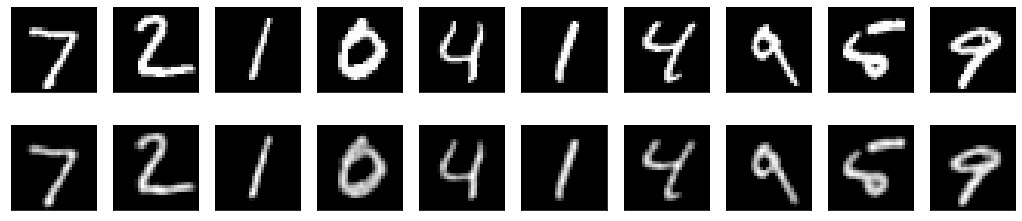

In [8]:
MNIST_AE_disp(x_test, decoded_img, [i for i in range(10)])

# Partie 2 : Vers le Denoising AE

## 2.1 Création des données bruitées

In [9]:
x_test_noise = x_test +  np.random.normal(0, .1, x_test.shape)
x_train_noise = x_train +  np.random.normal(0, .1, x_train.shape)

## 2.2 Prédictions à partir des données bruitées

In [10]:
autoencoder = model
# On génère un jeu de 10 images test au hasard
num_images=10
np.random.seed(42)
random_test_images=np.random.randint(x_test_noise.shape[0], size=num_images)

# On détermine l'image encodée et l'image décodée
decoded_img=autoencoder.predict(x_test_noise)
m1 = tf.keras.metrics.Accuracy()
_ = m1.update_state(decoded_img, x_test_noise)
print(m1.result().numpy())

0.0


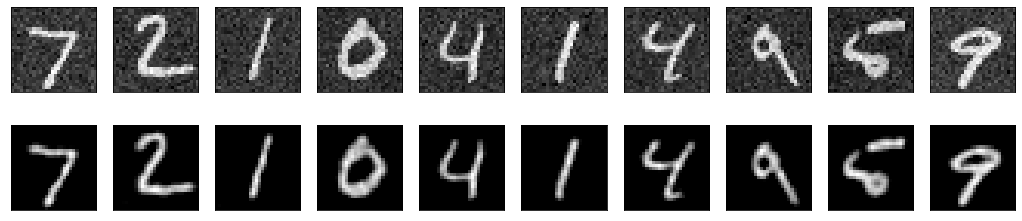

In [11]:
MNIST_AE_disp(x_test_noise, decoded_img, [i for i in range(10)])

## 2.3 Apprentissage du réseaux DAE

In [12]:
model = Sequential()

# Encoder ?
model.add(Conv2D(16, (3,3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(8, (3,3), activation='relu', padding='same'))

# Decoder ?
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2,2)))
model.add(Conv2D(1, (3,3), activation='relu', padding='same'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 2,633
Trainable params: 2,633
Non-trainable params: 0
____________________________________________________

In [13]:
# On entraine le réseau
batch_size = 256                                                             # tailles des mini-batch
epochs = 5                                                                 # nombre d'époques
history = model.fit(x_train_noise, x_train_noise, epochs=epochs, batch_size=batch_size,
                    validation_split=0.2)

Epoch 1/5
188/188 [==============================] - 54s 287ms/step - loss: 0.0865 - accuracy: 0.0000e+00 - val_loss: -0.0287 - val_accuracy: 0.0000e+00
Epoch 2/5
188/188 [==============================] - 54s 286ms/step - loss: -0.0425 - accuracy: 0.0000e+00 - val_loss: -0.0570 - val_accuracy: 0.0000e+00
Epoch 3/5
188/188 [==============================] - 54s 285ms/step - loss: -0.0751 - accuracy: 0.0000e+00 - val_loss: -0.0884 - val_accuracy: 0.0000e+00
Epoch 4/5
188/188 [==============================] - 54s 285ms/step - loss: -0.0858 - accuracy: 0.0000e+00 - val_loss: -0.1054 - val_accuracy: 0.0000e+00
Epoch 5/5
188/188 [==============================] - 54s 286ms/step - loss: -0.1002 - accuracy: 0.0000e+00 - val_loss: -0.1148 - val_accuracy: 0.0000e+00


## 2.4 Prédiction et visualisation à partir des données bruitées

In [14]:
autoencoder = model
# On génère un jeu de 10 images test au hasard
num_images=10
np.random.seed(42)
random_test_images=np.random.randint(x_test_noise.shape[0], size=num_images)

# On détermine l'image encodée et l'image décodée
decoded_img=autoencoder.predict(x_test_noise)
m2 = tf.keras.metrics.Accuracy()
_ = m2.update_state(decoded_img, x_test_noise)
print(m2.result().numpy())

0.0


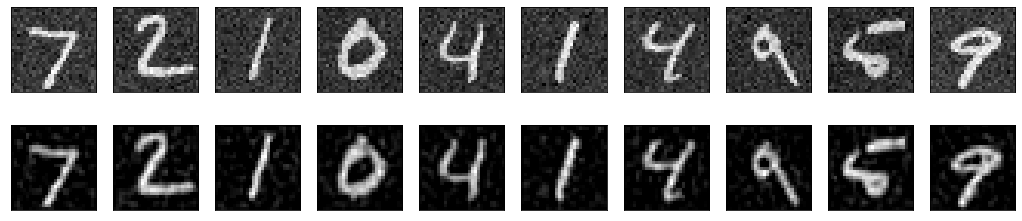

In [16]:
MNIST_AE_disp(x_test_noise, decoded_img, [i for i in range(10)])